In [1]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_points_from_path(path_segment, num_samples=100):
    if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
        return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
    return []

In [3]:
svg_file = './data/problems/frag0.svg' 
paths, _ = svg2paths(svg_file)

all_points = []
for curve_index, path in enumerate(paths):
    for segment in path:
        points = extract_points_from_path(segment)
        all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])

with open('out.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'constant', 'x', 'y'])
    for index, constant, x, y in all_points:
        writer.writerow([index, constant, np.float64(x), np.float64(y)])

In [4]:
def euclidean_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    return np.linalg.norm(point1 - point2)

def rdp(points: np.ndarray, epsilon: float) -> List[Tuple[float, float]]:
    dmax = 0
    index = 0
    end = len(points)
    for i in range(1, end - 1):
        d = euclidean_distance(points[i], points[0]) + euclidean_distance(points[i], points[-1]) - euclidean_distance(points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        results1 = rdp(points[:index + 1], epsilon)
        results2 = rdp(points[index:], epsilon)
        return results1[:-1] + results2
    else:
        return [tuple(points[0]), tuple(points[-1])]

def average_close_vertices(curves: defaultdict, tolerance: float) -> defaultdict:
    all_points = []
    for points in curves.values():
        all_points.extend(points)

    clusters = []
    for point in all_points:
        added = False
        for cluster in clusters:
            if any(euclidean_distance(np.array(cp), np.array(point)) <= tolerance for cp in cluster):
                cluster.append(point)
                added = True
                break
        if not added:
            clusters.append([point])

    averaged_points = {}
    for cluster in clusters:
        avg_point = tuple(np.mean(cluster, axis=0))
        for point in cluster:
            averaged_points[point] = avg_point

    new_curves = defaultdict(list)
    for curve_no, points in curves.items():
        new_points = [averaged_points[point] for point in points]
        new_curves[curve_no] = new_points

    return new_curves

In [5]:
curves = defaultdict(list)
with open('out.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  
    for row in reader:
        try:
            curve_no = int(float(row[0])) 
            x = float(row[2])
            y = float(row[3])
            curves[curve_no].append((x, y))
        except ValueError as e:
            print(f"Skipping line due to error: {e}")

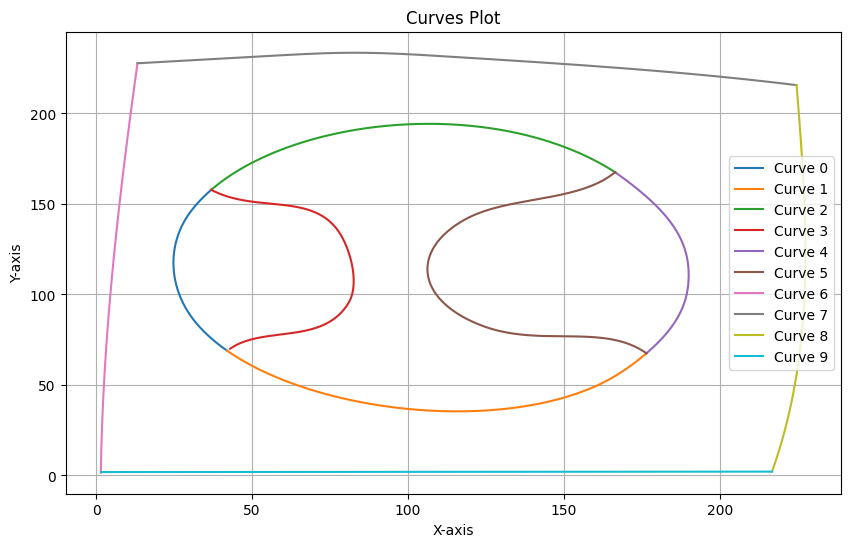

In [33]:
plt.figure(figsize=(10, 6))

for index, points in curves.items():
    x_values, y_values = zip(*points)  # Unpack the list of tuples into two lists: x_values and y_values
    plt.plot(x_values, y_values, label=f'Curve {index}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Curves Plot')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
epsilon_initial = 1.5  
simplified_curves = defaultdict(list)
for curve_no, points in curves.items():
    points_array = np.array(points)
    simplified_points = rdp(points_array, epsilon_initial)
    simplified_curves[curve_no] = simplified_points

In [8]:
simplified_curves

defaultdict(list,
            {0: [(41.942, 68.98),
              (24.879349361382413, 113.25390232907588),
              (36.89100000000002, 157.80800000000002)],
             1: [(176.5, 67.5),
              (153.66719283643496, 44.950373247833916),
              (121.20065848465265, 35.57279582066971),
              (77.20529629629624, 43.384074074074086),
              (41.941999999999894, 68.98000000000002)],
             2: [(36.891, 157.808),
              (63.655899453673555, 182.66043734147925),
              (101.3309385220432, 194.11631178842805),
              (136.48421876246394, 188.60492946194924),
              (166.49999999999997, 167.4999999999998)],
             3: [(42.964, 70.031),
              (74.74200380089023, 84.78426748455887),
              (82.3230108512943, 101.95348421053716),
              (73.35825770097672, 142.4150728775357),
              (36.89100000000001, 157.80800000000002)],
             4: [(166.5, 167.5),
              (189.66831254695717, 11

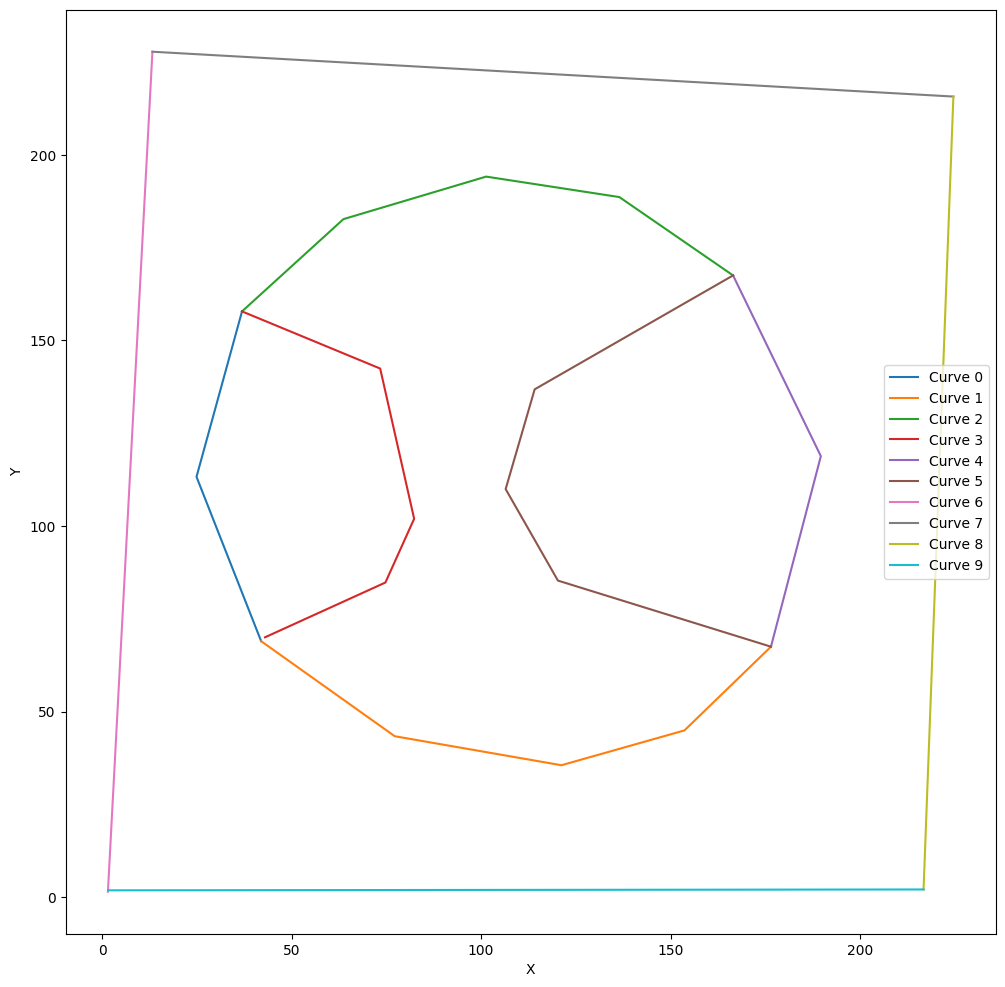

In [9]:
plt.figure(figsize=(12, 12))
for curve_no, points in simplified_curves.items():
    final_points_x, final_points_y = zip(*points)
    plt.plot(final_points_x, final_points_y, label=f'Curve {curve_no}')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [10]:
from collections import defaultdict
import math

# Input dictionary of polylines


# Helper function to check if two points are near each other
def points_near(p1, p2, threshold=2.0):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) < threshold

# Helper function to find the midpoint between two points
def midpoint(p1, p2):
    return ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

# Create an empty adjacency list
adj_list = defaultdict(list)

# Iterate through each pair of polylines and update their endpoints if they are near
for i in range(len(simplified_curves)):
    for j in range(len(simplified_curves)):
        if i != j:
            polyline_i = simplified_curves[i]
            polyline_j = simplified_curves[j]
            for index_i, point_i in enumerate(polyline_i):
                for index_j, point_j in enumerate(polyline_j):
                    if points_near(point_i, point_j):
                        # Calculate the midpoint
                        mid_point = midpoint(point_i, point_j)
                        # Update the endpoints in the original polylines
                        simplified_curves[i][index_i] = mid_point
                        simplified_curves[j][index_j] = mid_point

simplified_curves = {k: [(round(x, 2), round(y, 2)) for x, y in v] for k, v in simplified_curves.items()}
print("Updated Polylines:")
for key, value in simplified_curves.items():
    print(f"{key}: {value}")




Updated Polylines:
0: [(42.26, 69.31), (24.88, 113.25), (36.89, 157.81)]
1: [(176.5, 67.5), (153.67, 44.95), (121.2, 35.57), (77.21, 43.38), (42.29, 69.34)]
2: [(36.89, 157.81), (63.66, 182.66), (101.33, 194.12), (136.48, 188.6), (166.5, 167.5)]
3: [(42.29, 69.34), (74.74, 84.78), (82.32, 101.95), (73.36, 142.42), (36.89, 157.81)]
4: [(166.5, 167.5), (189.67, 118.82), (176.5, 67.5)]
5: [(176.5, 67.5), (120.27, 85.31), (106.47, 109.95), (114.13, 136.82), (166.5, 167.5)]
6: [(13.24, 227.76), (1.53, 1.69)]
7: [(224.65, 215.68), (13.24, 227.76)]
8: [(216.78, 2.11), (224.65, 215.68)]
9: [(1.53, 1.69), (216.78, 2.11)]


In [11]:
def convert_polylines_to_lines(curves: defaultdict) -> defaultdict:
    new_curves = defaultdict(list)
    line_index = 0
    for curve_no, points in curves.items():
        if len(points) > 1:
            for i in range(len(points) - 1):
                new_curves[line_index].append(points[i])
                new_curves[line_index].append(points[i + 1])
                line_index += 1
    return new_curves

def merge_lines(curves: defaultdict, slope_tol: float = 0.5, dist_tol: float = 0.5) -> defaultdict:
    merged_lines = defaultdict(list)
    lines = []
    
    for points in curves.values():
        for i in range(0, len(points), 2):
            lines.append((points[i], points[i+1]))

    merged = [False] * len(lines)

    for i in range(len(lines)):
        # if merged[i]:
        #     continue
        line1 = lines[i]
        p1, p2 = line1
        merged_lines[len(merged_lines)] = [p1, p2]
        for j in range(i + 1, len(lines)):
            # if merged[j]:
            #     continue
            line2 = lines[j]
            q1, q2 = line2
            if (euclidean_distance(np.array(p2), np.array(q1)) <= dist_tol or
                euclidean_distance(np.array(p2), np.array(q2)) <= dist_tol):
                merged[i] = True
                merged[j] = True
                p2 = q2 if euclidean_distance(np.array(p2), np.array(q2)) < euclidean_distance(np.array(p2), np.array(q1)) else q1
                merged_lines[len(merged_lines)-1] = [p1, p2]

    return merged_lines

defaultdict(<class 'list'>, {0: [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588)], 1: [(24.879349361382413, 113.25390232907588), (36.89100000000001, 157.808)], 2: [(176.5, 67.5), (153.66719283643496, 44.950373247833916)], 3: [(153.66719283643496, 44.950373247833916), (121.20065848465265, 35.57279582066971)], 4: [(121.20065848465265, 35.57279582066971), (77.20529629629624, 43.384074074074086)], 5: [(77.20529629629624, 43.384074074074086), (42.282666666666636, 69.33033333333334)], 6: [(36.89100000000001, 157.808), (63.655899453673555, 182.66043734147925)], 7: [(63.655899453673555, 182.66043734147925), (101.3309385220432, 194.11631178842805)], 8: [(101.3309385220432, 194.11631178842805), (136.48421876246394, 188.60492946194924)], 9: [(136.48421876246394, 188.60492946194924), (166.5, 167.50033333333326)], 10: [(42.282666666666636, 69.33033333333334), (74.74200380089023, 84.78426748455887)], 11: [(74.74200380089023, 84.78426748455887), (82.3230108512943, 10

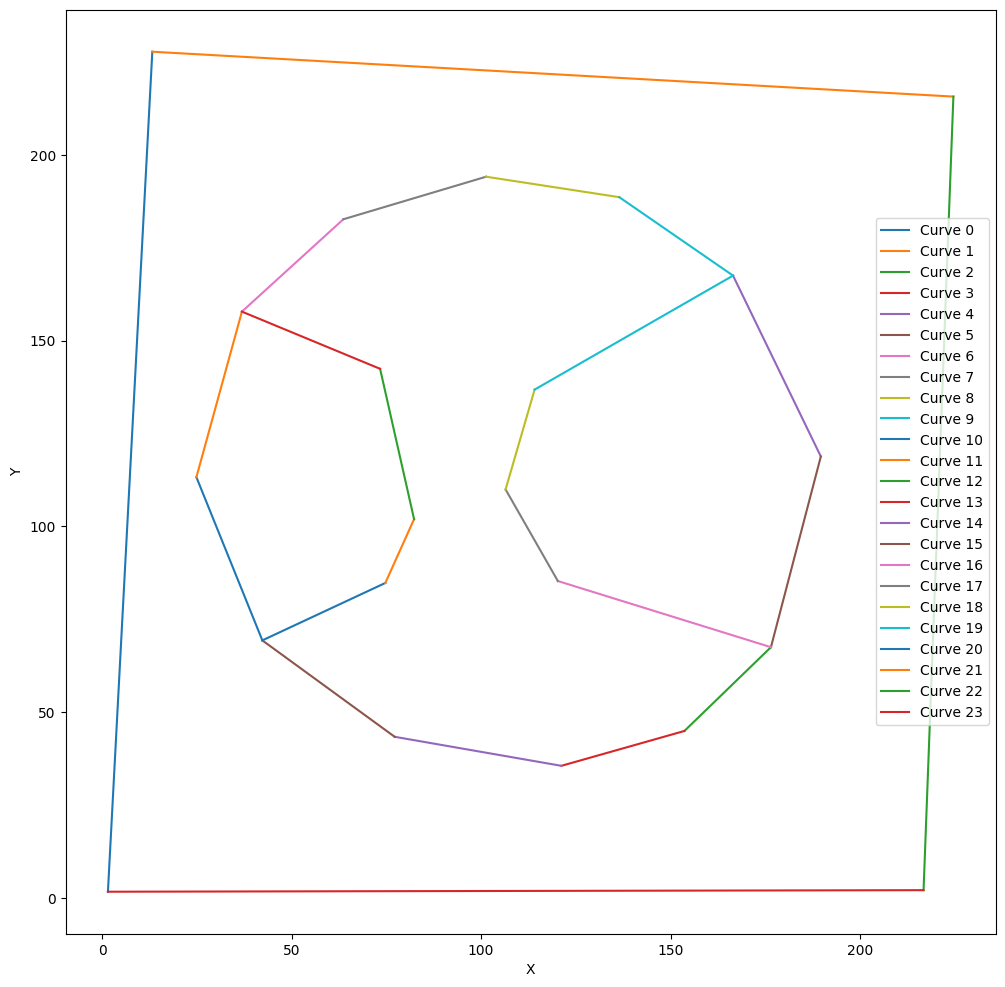

In [12]:
epsilon_initial = 1.5  
simplified_curves = defaultdict(list)
for curve_no, points in curves.items():
    points_array = np.array(points)
    simplified_points = rdp(points_array, epsilon_initial)
    simplified_curves[curve_no] = simplified_points

simplified_curves = convert_polylines_to_lines(simplified_curves)

tolerance = 5
averaged_curves = average_close_vertices(simplified_curves, tolerance)

epsilon_final = 1.5 
final_curves = defaultdict(list)
for curve_no, points in averaged_curves.items():
    points_array = np.array(points)
    final_points = rdp(points_array, epsilon_final)
    final_curves[curve_no] = final_points

final_curves = convert_polylines_to_lines(final_curves)
final_curves = merge_lines(final_curves)

print(final_curves)

plt.figure(figsize=(12, 12))
for curve_no, points in final_curves.items():
    final_points_x, final_points_y = zip(*points)
    plt.plot(final_points_x, final_points_y, label=f'Curve {curve_no}')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [13]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 12))
# for curve_no, points in simplified_curves.items():
#     final_points_x, final_points_y = zip(*points)
#     plt.plot(final_points_x, final_points_y, label=f'Curve {curve_no}')

# plt.legend()
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

In [14]:
simplified_curves

defaultdict(list,
            {0: [(41.942, 68.98), (24.879349361382413, 113.25390232907588)],
             1: [(24.879349361382413, 113.25390232907588),
              (36.89100000000002, 157.80800000000002)],
             2: [(176.5, 67.5), (153.66719283643496, 44.950373247833916)],
             3: [(153.66719283643496, 44.950373247833916),
              (121.20065848465265, 35.57279582066971)],
             4: [(121.20065848465265, 35.57279582066971),
              (77.20529629629624, 43.384074074074086)],
             5: [(77.20529629629624, 43.384074074074086),
              (41.941999999999894, 68.98000000000002)],
             6: [(36.891, 157.808), (63.655899453673555, 182.66043734147925)],
             7: [(63.655899453673555, 182.66043734147925),
              (101.3309385220432, 194.11631178842805)],
             8: [(101.3309385220432, 194.11631178842805),
              (136.48421876246394, 188.60492946194924)],
             9: [(136.48421876246394, 188.60492946194924),
    

In [15]:
for i in simplified_curves:
    for j in simplified_curves:
        if i != j:
            if any(points_near(p1, p2, threshold=3) for p1 in simplified_curves[i] for p2 in simplified_curves[j]):
                adj_list[i].append(j)
print("\nAdjacency List:")
print(dict(adj_list))


Adjacency List:
{0: [1, 5, 10], 1: [0, 6, 13], 2: [3, 15, 16], 3: [2, 4], 4: [3, 5], 5: [0, 4, 10], 6: [1, 7, 13], 7: [6, 8], 8: [7, 9], 9: [8, 14, 19], 10: [0, 5, 11], 11: [10, 12], 12: [11, 13], 13: [1, 6, 12], 14: [9, 15, 19], 15: [2, 14, 16], 16: [2, 15, 17], 17: [16, 18], 18: [17, 19], 19: [9, 14, 18], 20: [21, 23], 21: [20, 22], 22: [21, 23], 23: [20, 22]}


In [16]:
final_curves

defaultdict(list,
            {0: [(42.282666666666636, 69.33033333333334),
              (24.879349361382413, 113.25390232907588)],
             1: [(24.879349361382413, 113.25390232907588),
              (36.89100000000001, 157.808)],
             2: [(176.5, 67.5), (153.66719283643496, 44.950373247833916)],
             3: [(153.66719283643496, 44.950373247833916),
              (121.20065848465265, 35.57279582066971)],
             4: [(121.20065848465265, 35.57279582066971),
              (77.20529629629624, 43.384074074074086)],
             5: [(77.20529629629624, 43.384074074074086),
              (42.282666666666636, 69.33033333333334)],
             6: [(36.89100000000001, 157.808),
              (63.655899453673555, 182.66043734147925)],
             7: [(63.655899453673555, 182.66043734147925),
              (101.3309385220432, 194.11631178842805)],
             8: [(101.3309385220432, 194.11631178842805),
              (136.48421876246394, 188.60492946194924)],
           

In [17]:
from collections import defaultdict, deque

# Define the lines
lines = {0: [(42.282666666666636, 69.33033333333334),
              (24.879349361382413, 113.25390232907588)],
         1: [(24.879349361382413, 113.25390232907588),
              (36.89100000000001, 157.808)],
         2: [(176.5, 67.5), (153.66719283643496, 44.950373247833916)],
         3: [(153.66719283643496, 44.950373247833916),
              (121.20065848465265, 35.57279582066971)],
         4: [(121.20065848465265, 35.57279582066971),
              (77.20529629629624, 43.384074074074086)],
         5: [(77.20529629629624, 43.384074074074086),
              (42.282666666666636, 69.33033333333334)],
         6: [(36.89100000000001, 157.808),
              (63.655899453673555, 182.66043734147925)],
         7: [(63.655899453673555, 182.66043734147925),
              (101.3309385220432, 194.11631178842805)],
         8: [(101.3309385220432, 194.11631178842805),
              (136.48421876246394, 188.60492946194924)],
         9: [(136.48421876246394, 188.60492946194924),
              (166.5, 167.50033333333326)],
         10: [(42.282666666666636, 69.33033333333334),
              (74.74200380089023, 84.78426748455887)],
         11: [(74.74200380089023, 84.78426748455887),
              (82.3230108512943, 101.95348421053716)],
         12: [(82.3230108512943, 101.95348421053716),
              (73.35825770097672, 142.4150728775357)],
         13: [(73.35825770097672, 142.4150728775357),
              (36.89100000000001, 157.808)],
         14: [(166.5, 167.50033333333326),
              (189.66831254695717, 118.82019684447786)],
         15: [(189.66831254695717, 118.82019684447786), (176.5, 67.5)],
         16: [(176.5, 67.5), (120.26890728218828, 85.30569527228205)],
         17: [(120.26890728218828, 85.30569527228205),
              (106.47246054463623, 109.9486760184232)],
         18: [(106.47246054463623, 109.9486760184232),
              (114.13354036023944, 136.82039894094504)],
         19: [(114.13354036023944, 136.82039894094504),
              (166.5, 167.50033333333326)],
         20: [(13.244999999999997, 227.755),
              (1.531000000000001, 1.6880000000000142)],
         21: [(224.647, 215.68000000000004),
              (13.244999999999997, 227.755)],
         22: [(216.77750000000003, 2.107), (224.647, 215.68000000000004)],
         23: [(1.531000000000001, 1.6880000000000142),
              (216.77750000000003, 2.107)]}

# Build graph
graph = defaultdict(list)
for line in lines.values():
    graph[line[0]].append(line[1])
    graph[line[1]].append(line[0])

# Function to find all cycles in an undirected graph
def find_cycles(graph):
    def dfs(node, parent):
        visited[node] = True
        path.append(node)

        for neighbor in graph[node]:
            if not visited[neighbor]:
                dfs(neighbor, node)
            elif neighbor != parent and neighbor in path:
                cycle_start_index = path.index(neighbor)
                cycles.append(path[cycle_start_index:])

        path.pop()

    visited = defaultdict(bool)
    path = []
    cycles = []

    for node in graph:
        if not visited[node]:
            dfs(node, None)

    return cycles

# Find all cycles
cycles = find_cycles(graph)

# Print the detected cycles
for i, cycle in enumerate(cycles):
    print(f"Cycle {i + 1}: {cycle}")


Cycle 1: [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588), (36.89100000000001, 157.808), (63.655899453673555, 182.66043734147925), (101.3309385220432, 194.11631178842805), (136.48421876246394, 188.60492946194924), (166.5, 167.50033333333326), (189.66831254695717, 118.82019684447786), (176.5, 67.5), (153.66719283643496, 44.950373247833916), (121.20065848465265, 35.57279582066971), (77.20529629629624, 43.384074074074086)]
Cycle 2: [(166.5, 167.50033333333326), (189.66831254695717, 118.82019684447786), (176.5, 67.5), (120.26890728218828, 85.30569527228205), (106.47246054463623, 109.9486760184232), (114.13354036023944, 136.82039894094504)]
Cycle 3: [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588), (36.89100000000001, 157.808), (73.35825770097672, 142.4150728775357), (82.3230108512943, 101.95348421053716), (74.74200380089023, 84.78426748455887)]
Cycle 4: [(13.244999999999997, 227.755), (1.531000000000001, 1.6880000000000142

/tmp/ipykernel_7803/2062476557.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


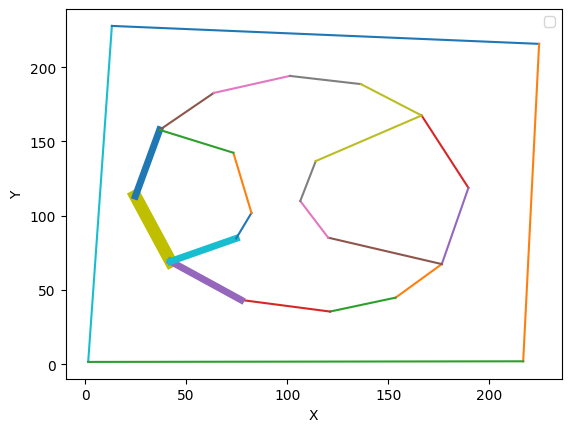

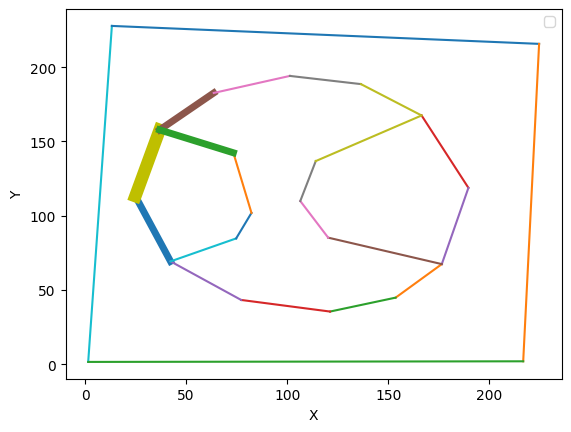

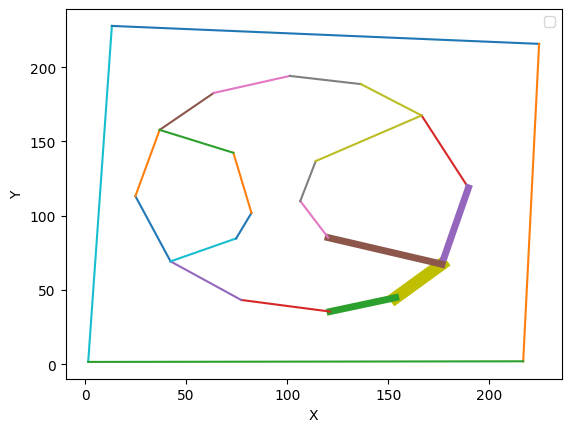

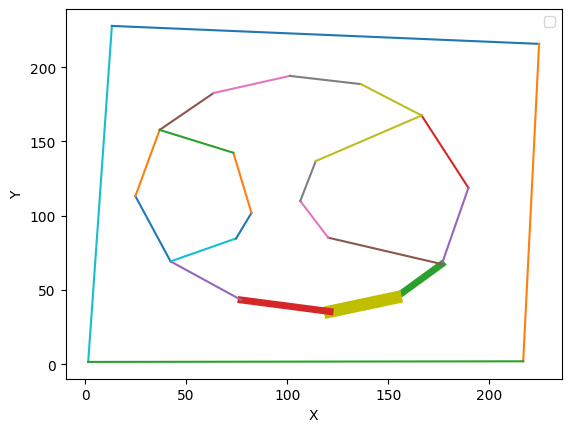

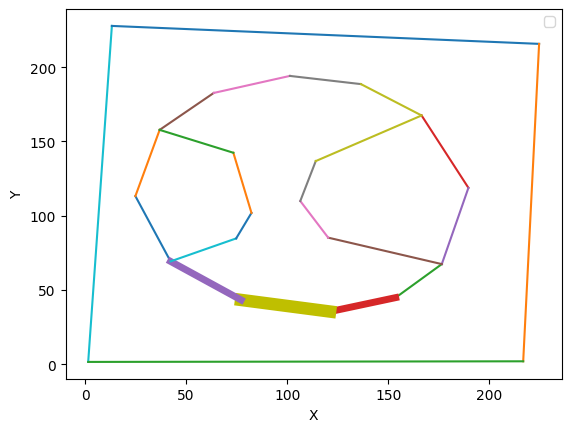

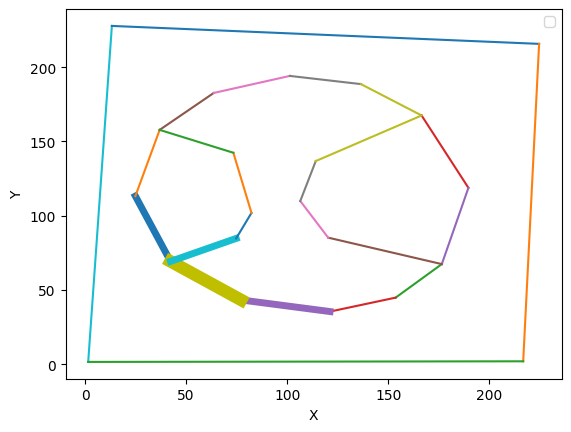

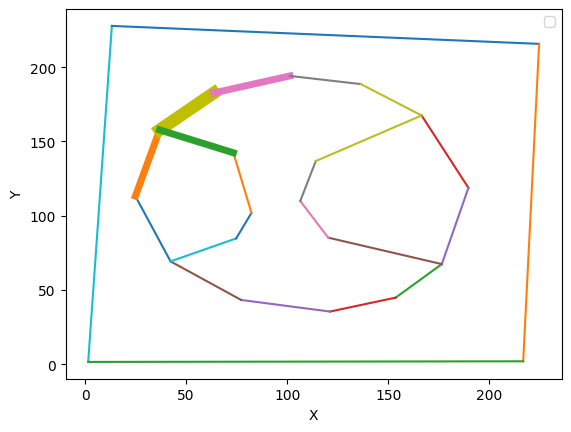

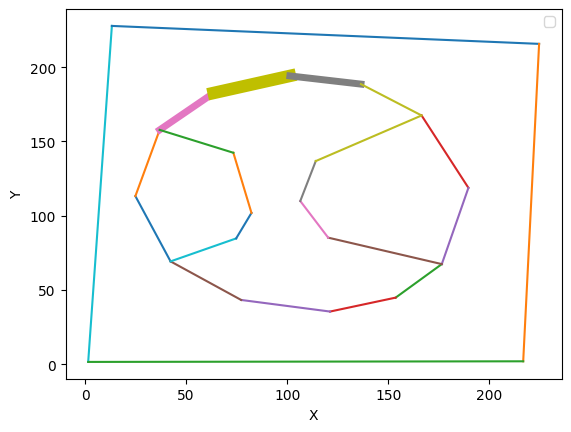

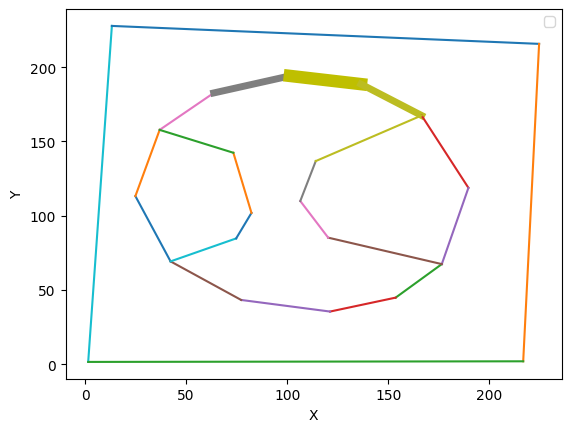

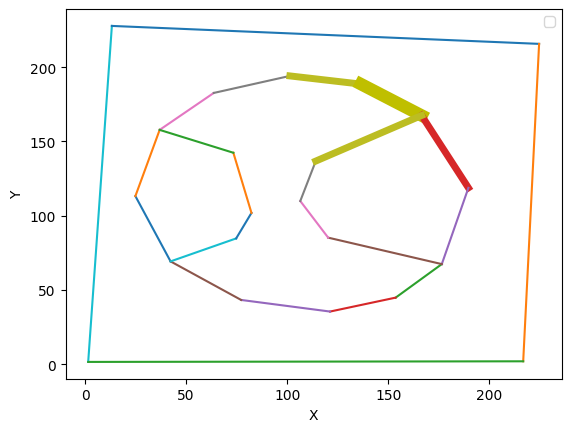

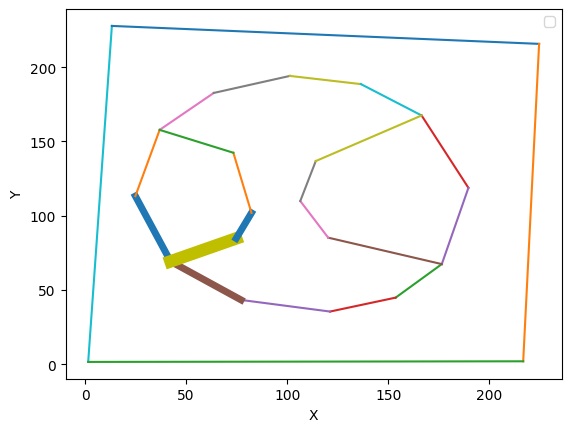

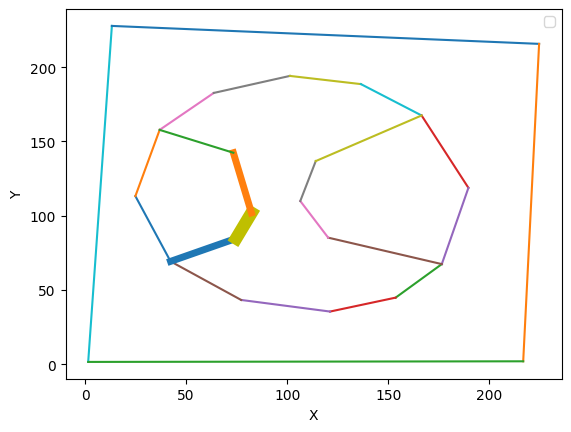

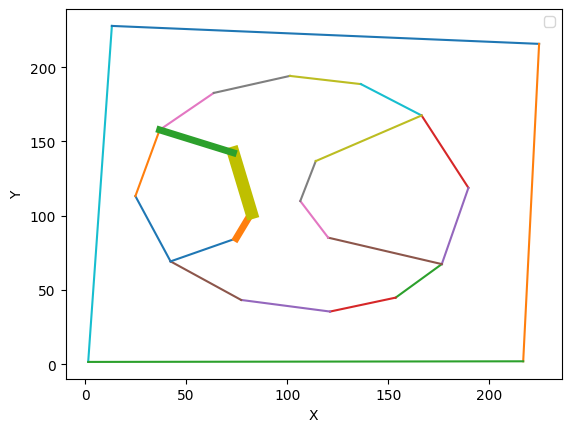

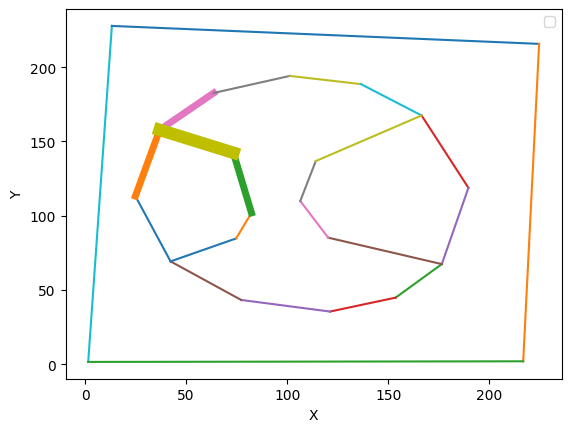

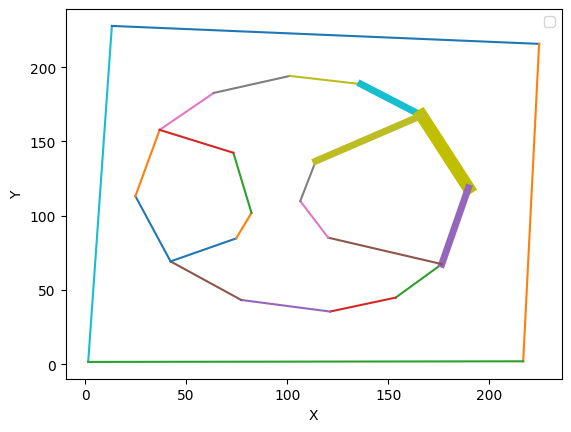

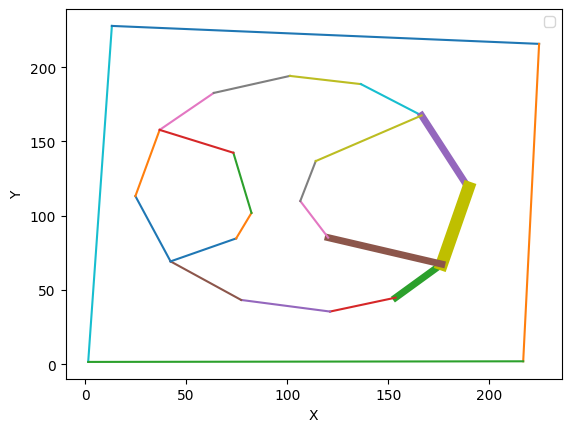

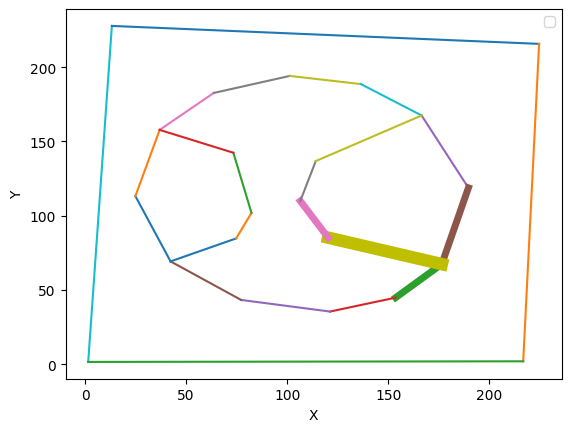

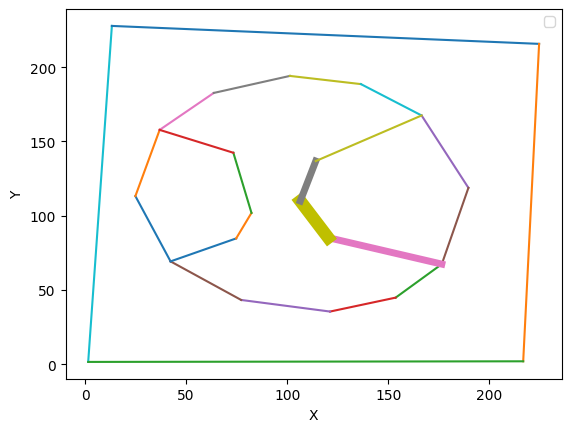

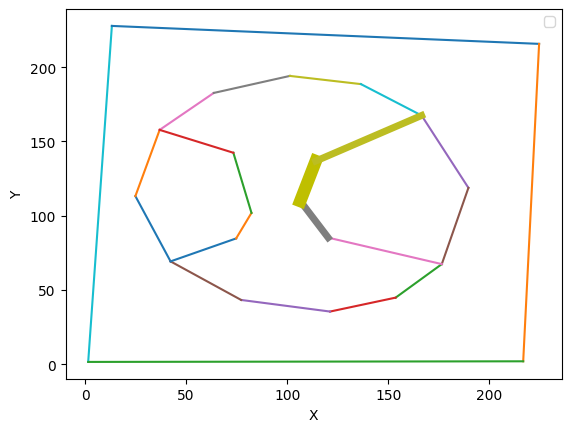

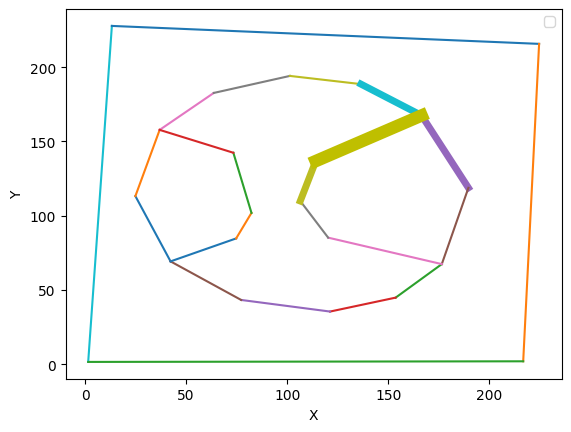

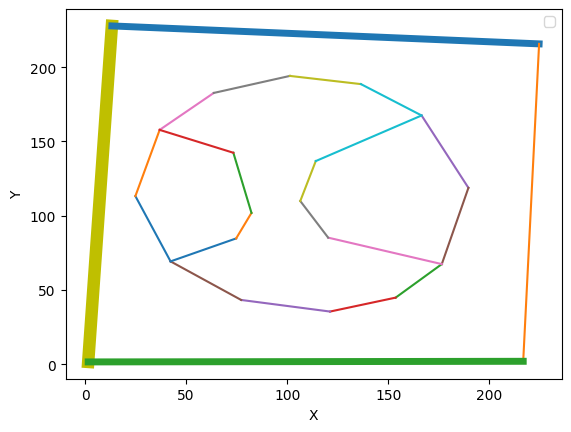

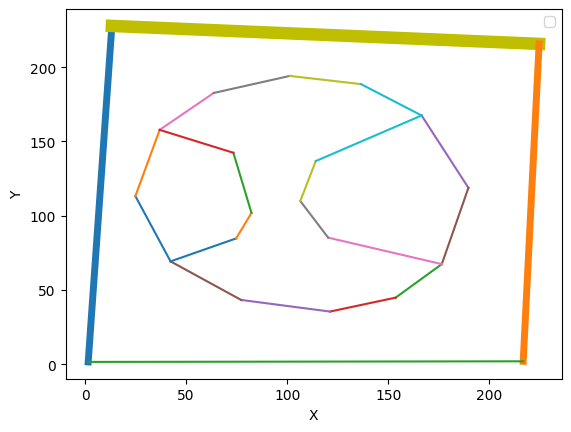

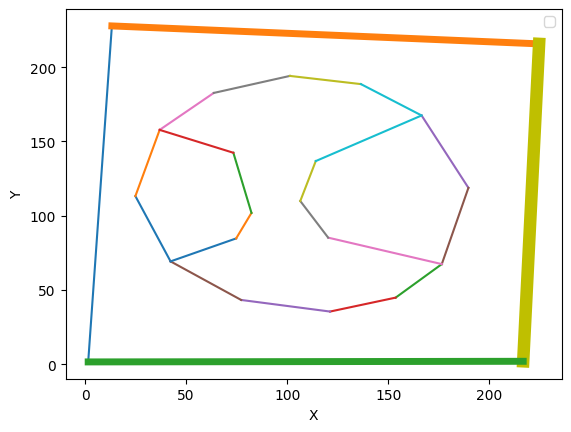

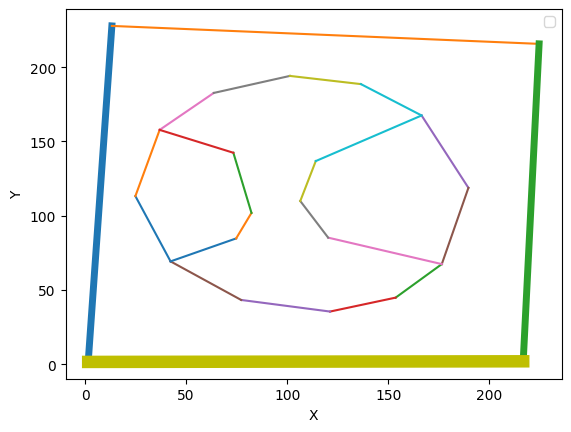

In [18]:
for key, pt in final_curves.items():
    for curve_no, points in final_curves.items():
        final_points_x, final_points_y = zip(*points)
        if (curve_no in adj_list[key]):
            plt.plot(final_points_x, final_points_y, linewidth=5)
        elif curve_no == key:
            plt.plot(final_points_x, final_points_y, linewidth=9, color="y")
        else:
            plt.plot(final_points_x, final_points_y)

    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

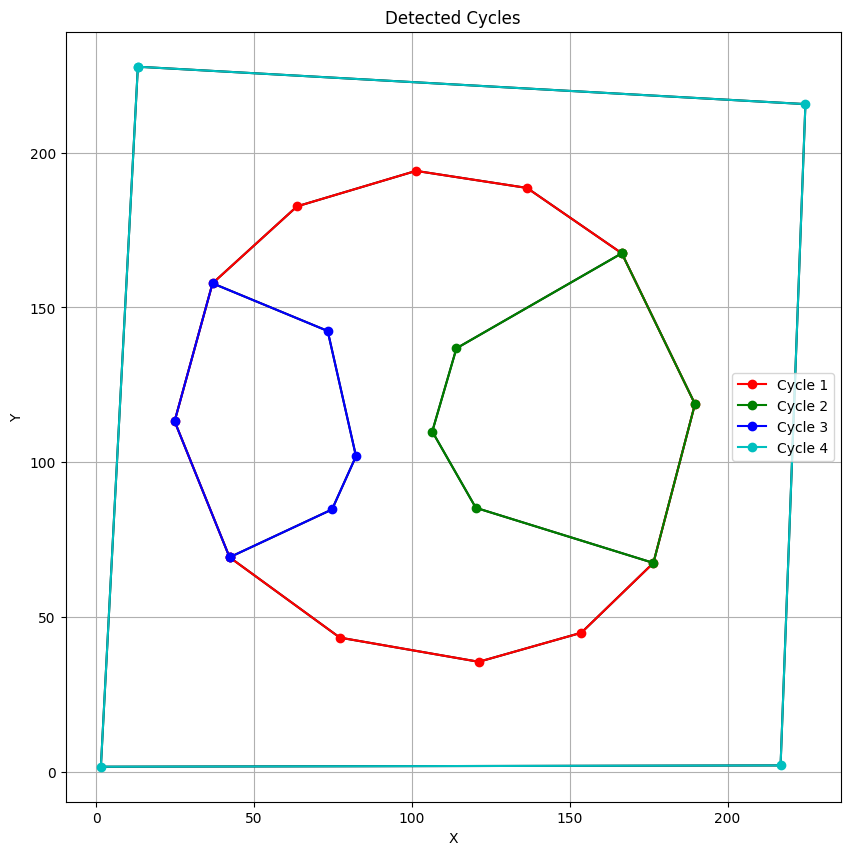

In [19]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the lines
lines = {0: [(42.282666666666636, 69.33033333333334),
              (24.879349361382413, 113.25390232907588)],
         1: [(24.879349361382413, 113.25390232907588),
              (36.89100000000001, 157.808)],
         2: [(176.5, 67.5), (153.66719283643496, 44.950373247833916)],
         3: [(153.66719283643496, 44.950373247833916),
              (121.20065848465265, 35.57279582066971)],
         4: [(121.20065848465265, 35.57279582066971),
              (77.20529629629624, 43.384074074074086)],
         5: [(77.20529629629624, 43.384074074074086),
              (42.282666666666636, 69.33033333333334)],
         6: [(36.89100000000001, 157.808),
              (63.655899453673555, 182.66043734147925)],
         7: [(63.655899453673555, 182.66043734147925),
              (101.3309385220432, 194.11631178842805)],
         8: [(101.3309385220432, 194.11631178842805),
              (136.48421876246394, 188.60492946194924)],
         9: [(136.48421876246394, 188.60492946194924),
              (166.5, 167.50033333333326)],
         10: [(42.282666666666636, 69.33033333333334),
              (74.74200380089023, 84.78426748455887)],
         11: [(74.74200380089023, 84.78426748455887),
              (82.3230108512943, 101.95348421053716)],
         12: [(82.3230108512943, 101.95348421053716),
              (73.35825770097672, 142.4150728775357)],
         13: [(73.35825770097672, 142.4150728775357),
              (36.89100000000001, 157.808)],
         14: [(166.5, 167.50033333333326),
              (189.66831254695717, 118.82019684447786)],
         15: [(189.66831254695717, 118.82019684447786), (176.5, 67.5)],
         16: [(176.5, 67.5), (120.26890728218828, 85.30569527228205)],
         17: [(120.26890728218828, 85.30569527228205),
              (106.47246054463623, 109.9486760184232)],
         18: [(106.47246054463623, 109.9486760184232),
              (114.13354036023944, 136.82039894094504)],
         19: [(114.13354036023944, 136.82039894094504),
              (166.5, 167.50033333333326)],
         20: [(13.244999999999997, 227.755),
              (1.531000000000001, 1.6880000000000142)],
         21: [(224.647, 215.68000000000004),
              (13.244999999999997, 227.755)],
         22: [(216.77750000000003, 2.107), (224.647, 215.68000000000004)],
         23: [(1.531000000000001, 1.6880000000000142),
              (216.77750000000003, 2.107)]}

# Build graph
graph = defaultdict(list)
for line in lines.values():
    graph[line[0]].append(line[1])
    graph[line[1]].append(line[0])

# Function to find all cycles in an undirected graph
def find_cycles(graph):
    def dfs(node, parent):
        visited[node] = True
        path.append(node)

        for neighbor in graph[node]:
            if not visited[neighbor]:
                dfs(neighbor, node)
            elif neighbor != parent and neighbor in path:
                cycle_start_index = path.index(neighbor)
                cycles.append(path[cycle_start_index:] + [neighbor])

        path.pop()

    visited = defaultdict(bool)
    path = []
    cycles = []

    for node in graph:
        if not visited[node]:
            dfs(node, None)

    return cycles

# Find all cycles
cycles = find_cycles(graph)

# Plotting the lines and cycles
plt.figure(figsize=(10, 10))
for line in lines.values():
    x, y = zip(*line)
    plt.plot(x, y, 'k-')

# Different colors for different cycles
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']
for i, cycle in enumerate(cycles):
    x, y = zip(*cycle)
    color = colors[i % len(colors)]
    plt.plot(x, y, color=color, marker='o', label=f'Cycle {i + 1}')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Detected Cycles')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
cycles

[[(42.282666666666636, 69.33033333333334),
  (24.879349361382413, 113.25390232907588),
  (36.89100000000001, 157.808),
  (63.655899453673555, 182.66043734147925),
  (101.3309385220432, 194.11631178842805),
  (136.48421876246394, 188.60492946194924),
  (166.5, 167.50033333333326),
  (189.66831254695717, 118.82019684447786),
  (176.5, 67.5),
  (153.66719283643496, 44.950373247833916),
  (121.20065848465265, 35.57279582066971),
  (77.20529629629624, 43.384074074074086),
  (42.282666666666636, 69.33033333333334)],
 [(166.5, 167.50033333333326),
  (189.66831254695717, 118.82019684447786),
  (176.5, 67.5),
  (120.26890728218828, 85.30569527228205),
  (106.47246054463623, 109.9486760184232),
  (114.13354036023944, 136.82039894094504),
  (166.5, 167.50033333333326)],
 [(42.282666666666636, 69.33033333333334),
  (24.879349361382413, 113.25390232907588),
  (36.89100000000001, 157.808),
  (73.35825770097672, 142.4150728775357),
  (82.3230108512943, 101.95348421053716),
  (74.74200380089023, 84.78

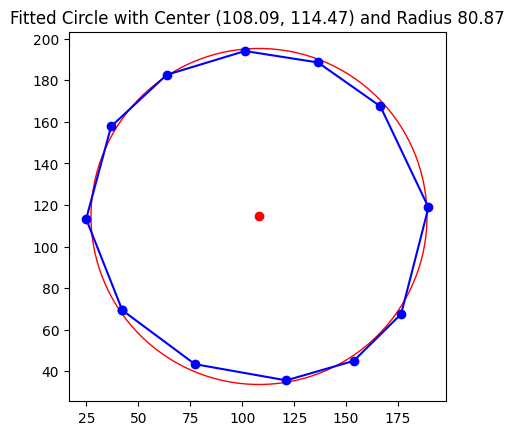

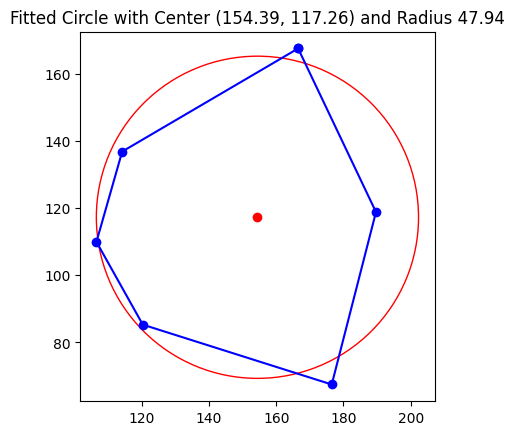

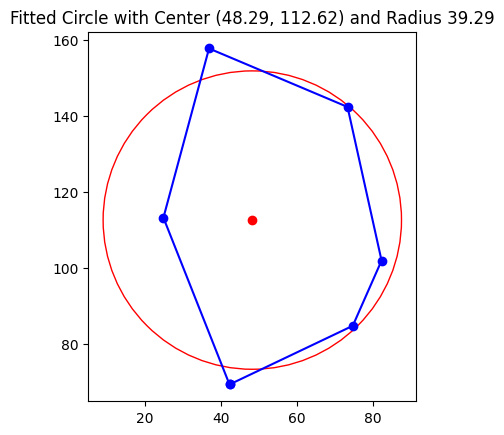

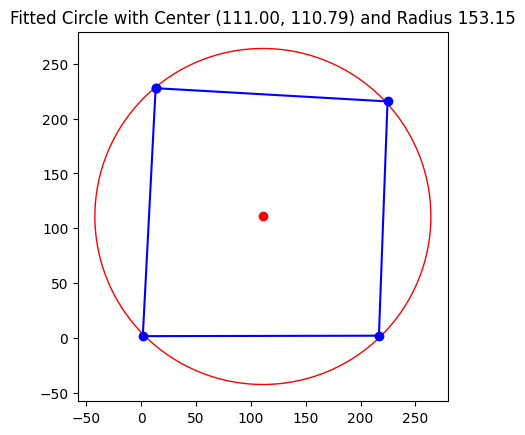

Polygon 1 fitting error: 3.3526338640715894
Polygon 2 fitting error: 34.5193827618696
Polygon 3 fitting error: 51.20036097424771
Polygon 4 fitting error: 1.493141048906185


In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the polygons
polygons = [
    [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588),
     (36.89100000000001, 157.808), (63.655899453673555, 182.66043734147925),
     (101.3309385220432, 194.11631178842805), (136.48421876246394, 188.60492946194924),
     (166.5, 167.50033333333326), (189.66831254695717, 118.82019684447786),
     (176.5, 67.5), (153.66719283643496, 44.950373247833916), 
     (121.20065848465265, 35.57279582066971), (77.20529629629624, 43.384074074074086),
     (42.282666666666636, 69.33033333333334)],
    [(166.5, 167.50033333333326), (189.66831254695717, 118.82019684447786),
     (176.5, 67.5), (120.26890728218828, 85.30569527228205),
     (106.47246054463623, 109.9486760184232), (114.13354036023944, 136.82039894094504),
     (166.5, 167.50033333333326)],
    [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588),
     (36.89100000000001, 157.808), (73.35825770097672, 142.4150728775357),
     (82.3230108512943, 101.95348421053716), (74.74200380089023, 84.78426748455887),
     (42.282666666666636, 69.33033333333334)],
    [(13.244999999999997, 227.755), (1.531000000000001, 1.6880000000000142),
     (216.77750000000003, 2.107), (224.647, 215.68000000000004),
     (13.244999999999997, 227.755)]
]

def fit_circle(points):
    # Points should be in a numpy array
    points = np.array(points)
    
    # The centroid of the points
    x_m = np.mean(points[:, 0])
    y_m = np.mean(points[:, 1])
    
    # Subtract mean
    u = points[:, 0] - x_m
    v = points[:, 1] - y_m
    
    # Least squares fitting
    Suv  = np.sum(u*v)
    Suu  = np.sum(u**2)
    Svv  = np.sum(v**2)
    Suuv = np.sum(u**2 * v)
    Suvv = np.sum(u * v**2)
    Suuu = np.sum(u**3)
    Svvv = np.sum(v**3)
    
    # Solving the linear system
    A = np.array([[Suu, Suv], [Suv, Svv]])
    B = np.array([0.5 * (Suuu + Suvv), 0.5 * (Svvv + Suuv)])
    uc, vc = np.linalg.solve(A, B)
    
    xc_1 = x_m + uc
    yc_1 = y_m + vc
    R_1 = np.sqrt(uc**2 + vc**2 + (Suu + Svv) / len(points))
    
    return xc_1, yc_1, R_1

def calculate_error(points, xc, yc, R):
    points = np.array(points)
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    error = np.mean((distances - R)**2)
    return error

# Fitting circles and calculating errors
fitted_circles = []
errors = []

for polygon in polygons:
    xc, yc, R = fit_circle(polygon)
    error = calculate_error(polygon, xc, yc, R)
    fitted_circles.append((xc, yc, R))
    errors.append(error)

    # Plot the polygon and fitted circle
    polygon = np.array(polygon)
    plt.plot(polygon[:, 0], polygon[:, 1], 'b-', marker='o')
    circle = plt.Circle((xc, yc), R, color='r', fill=False)
    plt.gca().add_patch(circle)

    plt.scatter(xc, yc, color='r')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Fitted Circle with Center ({xc:.2f}, {yc:.2f}) and Radius {R:.2f}')
    plt.show()

# Print errors
for i, error in enumerate(errors):
    print(f'Polygon {i + 1} fitting error: {error}')


In [22]:
import numpy as np

def fit_circle(points):
    # Convert points to numpy array
    points = np.array(points)
    
    # Compute the centroid of the points
    x_m = np.mean(points[:, 0])
    y_m = np.mean(points[:, 1])
    
    # Subtract mean
    u = points[:, 0] - x_m
    v = points[:, 1] - y_m
    
    # Compute the components required for circle fitting
    Suv  = np.sum(u*v)
    Suu  = np.sum(u**2)
    Svv  = np.sum(v**2)
    Suuv = np.sum(u**2 * v)
    Suvv = np.sum(u * v**2)
    Suuu = np.sum(u**3)
    Svvv = np.sum(v**3)
    
    # Solve the linear system
    A = np.array([[Suu, Suv], [Suv, Svv]])
    B = np.array([0.5 * (Suuu + Suvv), 0.5 * (Svvv + Suuv)])
    uc, vc = np.linalg.solve(A, B)
    
    # Circle center and radius
    xc = x_m + uc
    yc = y_m + vc
    R = np.sqrt(uc**2 + vc**2 + (Suu + Svv) / len(points))
    
    return xc, yc, R

def calculate_error(points, xc, yc, R):
    points = np.array(points)
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    error = np.mean((distances - R)**2)
    return error

def is_circle_like(polygon, min_sides=3, tolerance=1e-2):
    num_sides = len(polygon)
    
    if num_sides < min_sides:
        print(f"Polygon has {num_sides} sides, which is fewer than the minimum required {min_sides} sides.")
        return False

    xc, yc, R = fit_circle(polygon)
    error = calculate_error(polygon, xc, yc, R)
    
    print(f'Polygon has {num_sides} sides.')
    print(f'Circle Center: ({xc:.2f}, {yc:.2f}), Radius: {R:.2f}')
    print(f'Fitting Error: {error:.2f}')
    
    return error < tolerance

# Example polygon
polygon = [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588),
           (36.89100000000001, 157.808), (63.655899453673555, 182.66043734147925),
           (101.3309385220432, 194.11631178842805), (136.48421876246394, 188.60492946194924),
           (166.5, 167.50033333333326), (189.66831254695717, 118.82019684447786),
           (176.5, 67.5), (153.66719283643496, 44.950373247833916), 
           (121.20065848465265, 35.57279582066971), (77.20529629629624, 43.384074074074086),
           (42.282666666666636, 69.33033333333334)]

# Specify minimum number of sides and tolerance
min_sides = 12
tolerance = 5

# Determine if the polygon resembles a circle
if is_circle_like(polygon, min_sides, tolerance):
    print("The polygon resembles a circle.")
else:
    print("The polygon does not resemble a circle.")


Polygon has 13 sides.
Circle Center: (108.09, 114.47), Radius: 80.87
Fitting Error: 3.35
The polygon resembles a circle.


Polygon has 13 sides.
Circle Center: (108.09, 114.47), Radius: 80.87
Fitting Error: 3.35


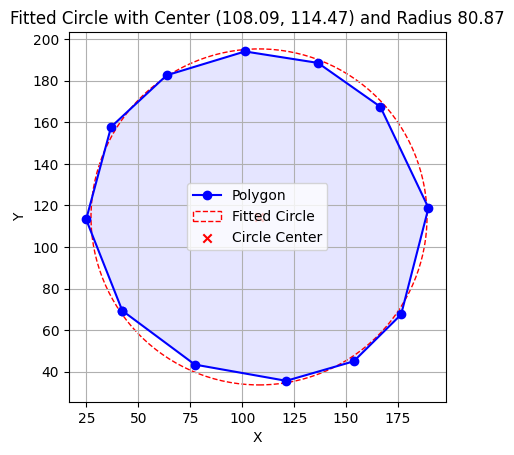

The polygon does not resemble a circle.


In [23]:
import numpy as np
import matplotlib.pyplot as plt

def fit_circle(points):
    # Convert points to numpy array
    points = np.array(points)
    
    # Compute the centroid of the points
    x_m = np.mean(points[:, 0])
    y_m = np.mean(points[:, 1])
    
    # Subtract mean
    u = points[:, 0] - x_m
    v = points[:, 1] - y_m
    
    # Compute the components required for circle fitting
    Suv  = np.sum(u*v)
    Suu  = np.sum(u**2)
    Svv  = np.sum(v**2)
    Suuv = np.sum(u**2 * v)
    Suvv = np.sum(u * v**2)
    Suuu = np.sum(u**3)
    Svvv = np.sum(v**3)
    
    # Solve the linear system
    A = np.array([[Suu, Suv], [Suv, Svv]])
    B = np.array([0.5 * (Suuu + Suvv), 0.5 * (Svvv + Suuv)])
    uc, vc = np.linalg.solve(A, B)
    
    # Circle center and radius
    xc = x_m + uc
    yc = y_m + vc
    R = np.sqrt(uc**2 + vc**2 + (Suu + Svv) / len(points))
    
    return xc, yc, R

def calculate_error(points, xc, yc, R):
    points = np.array(points)
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    error = np.mean((distances - R)**2)
    return error

def plot_polygon_and_circle(polygon, xc, yc, R):
    polygon = np.array(polygon)
    
    plt.figure()
    plt.plot(polygon[:, 0], polygon[:, 1], 'b-', marker='o', label='Polygon')
    plt.fill(polygon[:, 0], polygon[:, 1], 'b', alpha=0.1)  # Optional: Fill polygon with color
    
    # Plot the fitted circle
    circle = plt.Circle((xc, yc), R, color='r', fill=False, linestyle='--', label='Fitted Circle')
    plt.gca().add_patch(circle)
    
    # Plot the center of the circle
    plt.scatter(xc, yc, color='r', marker='x', label='Circle Center')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.title(f'Fitted Circle with Center ({xc:.2f}, {yc:.2f}) and Radius {R:.2f}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

def is_circle_like(polygon, min_sides=3, tolerance=1e-2):
    num_sides = len(polygon)
    
    if num_sides < min_sides:
        print(f"Polygon has {num_sides} sides, which is fewer than the minimum required {min_sides} sides.")
        return False

    xc, yc, R = fit_circle(polygon)
    error = calculate_error(polygon, xc, yc, R)
    
    print(f'Polygon has {num_sides} sides.')
    print(f'Circle Center: ({xc:.2f}, {yc:.2f}), Radius: {R:.2f}')
    print(f'Fitting Error: {error:.2f}')
    
    # Plot the polygon and fitted circle
    plot_polygon_and_circle(polygon, xc, yc, R)
    
    return error < tolerance

# Example polygon
polygon = [(42.282666666666636, 69.33033333333334), (24.879349361382413, 113.25390232907588),
           (36.89100000000001, 157.808), (63.655899453673555, 182.66043734147925),
           (101.3309385220432, 194.11631178842805), (136.48421876246394, 188.60492946194924),
           (166.5, 167.50033333333326), (189.66831254695717, 118.82019684447786),
           (176.5, 67.5), (153.66719283643496, 44.950373247833916), 
           (121.20065848465265, 35.57279582066971), (77.20529629629624, 43.384074074074086),
           (42.282666666666636, 69.33033333333334)]

# Specify minimum number of sides and tolerance
min_sides = 12
tolerance = 1e-2

# Determine if the polygon resembles a circle
if is_circle_like(polygon, min_sides, tolerance):
    print("The polygon resembles a circle.")
else:
    print("The polygon does not resemble a circle.")
